In [1]:
from itertools import chain, cycle, groupby, repeat
from collections import Counter
import json
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec

sys.path.append(r'C:\Users\hornu\OneDrive\Documents\repos\chart-singles\my_utils')

from list_utils import chunker
from pandas_utils import load_from_json, calculate_rolling_mean_std
from stat_utils import calculate_adjusted_density, calculate_adjusted_gini, \
                       calculate_histo_2d, calc_average_probability_from_coo_histo, collector

from plot_utils import  add_plots_to_axis, joint_plot, plot_raw_histo, plot_lines, plot_pair_grid

In [2]:
plt.rcParams.update({'font.size': 14})

# UK singles charts

These notes discuss trends in the British singles chart between 1953 and 2018 focussing on the record labels. We show that it is possible to derive conceptually simple measures from the charts which can charaterise the underlying dynamics of the record market.

## Introduction

### How to read this post?

The text is heavily interlaced with code blocks. These lines of codes are intended to illustrate the data flow. They can be glanced at or skipped altogether. The textual paragraphs and figures are hoped to provide enough explanation of the main logical steps and findings.

The raw notebook can be found [here]().

### Utilities

A considerable amount of functions and other utilities were written to facilitate the data analysis. They can be inspected in [this repository](https://github.com/bhornung/python-utilities).

## Data

### Data source

The United Kingdom singles chart data were obtained from [The Official Charts](https://www.officialcharts.com/charts/singles-chart/) online database 

### Limitations

#### Missing labels

There are 6216 chart positions out of 257,912 which do not have an associated label. These are denoted by `NO-LABEL` tag in the database. At the moment, they are treated as if they belonged to the same label. However, a better approach would be to assign a unique label to them.

#### Multiple labels, sublabels

There are 10,540 chart positions that are jointly issued by multiple labels _e.g Columbia/Interscope_ or belong to a sublabel, label--distributor pair _{e.g. Virgin/Charisma_. These compound labels are treated as individual entities. 

### Data preprocessing

The labels were cleaned, their string representation standardised and encoded using simple integer encoding. 

## Analysis

Evertything from under the sun and a place where it does not shine.

The integer encoded labels are loaded to the `label_series` list in the order (week1/pos1, week1/pos2, ..., week2/pos1, week2/pos2, ...).

In [3]:
path_to_db = r'C:\Users\hornu\OneDrive\Documents\repos\chart-singles\data-cleaning\scripts\singles-labels-encoded.json'
label_series = load_from_json(path_to_db)

The labels of the first ten positions on the first and second weeks:

In [4]:
print("First week top ten:", label_series[:10])
print("Second week top ten:", label_series[100:110])

First week top ten: [0, 1, 0, 1, 2, 1, 3, 3, 2, 4]
Second week top ten: [0, 1, 0, 2, 1, 3, 1, 1, 3, 2]


### Label counts

We explore how the positions are distributed among various labels. The unique label ids and the number of their apprearances are collected in the `counts_df` dataframe.

In [5]:
counts_df = pd.DataFrame(Counter(label_series).most_common(), columns = ['label', 'count'])
counts_df = counts_df[counts_df.label != 5]
counts_df['order'] = np.arange(len(counts_df))
counts_df['fraction'] = counts_df['count'].expanding().sum() / counts_df['count'].sum()

#### Histogram of labels

`counts_histo_df` is a histogram of the label frequencies _i.e._ how many times a label appeared.

In [6]:
counts_histo_df = counts_df.groupby(['count'])['count'].size()
counts_histo_df = pd.DataFrame(counts_histo_df).rename(columns = {'count' : 'nappear'}).reset_index()
counts_histo_df['fraction'] = counts_histo_df['nappear'].expanding().sum() / counts_histo_df['nappear'].sum()

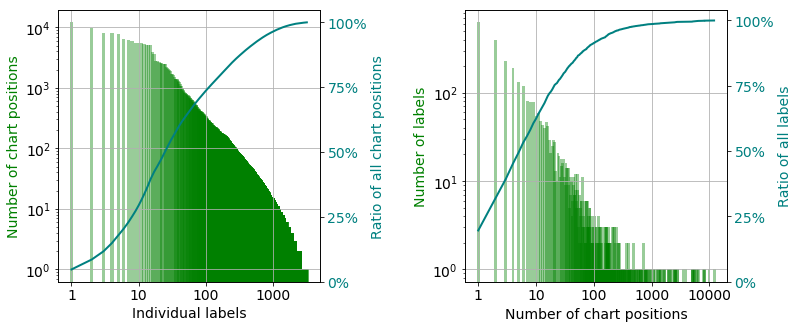

In [59]:
# TO SKIP -- plot setup

xn = np.log10(counts_df['order'] + 1); xh = np.log10(counts_histo_df['count'])
yn = counts_df['count']; yh = counts_histo_df['nappear'];
yncum = counts_df['fraction']; yhcum = counts_histo_df['fraction']

fig, axes = plt.subplots(1, 2, gridspec_kw = {'wspace' : 0.55})
fig.set_size_inches(12, 5)

plot_raw_histo(xn, yn, yncum, axes[0], 
               x1_label = "Individual labels", y1_label ="Number of chart positions", y2_label = "Ratio of all chart positions")

plot_raw_histo(xh, yh, yhcum, axes[1],
              x1_label = "Number of chart positions", y1_label = "Number of labels", y2_label = "Ratio of all labels")

There are approximately 3,200 unique labels which cover $~260,000$ chart positions between 1953 and 2018. The charts positions are not uniformly distributed between the labels. The six biggest labels cover $22\%$ of all positions, and $75\%$ of them owned by the hundred largest labels as the curve of the cumulative ratio shows in the left panel. If we group the label according to how many times they are featured on the charts, it is revealed that again around $22\%$ of all record labels had only one single that was on the chart only once (right panel). More interestingly, the cumulative ratio curve on the same panel tells us that $65\%$ percent of the labels only had maximum 10 positions. To summarise, there are much more labels with fewer hits than labels with hundreds or thousands of them.

### Time evolution of charts

In this section we break down the statistics to weeks and search for trends across the decades.

#### Chart descriptors

A handful of useful descriptors are introduced below which will help up to quantify the weekly changes of the charts. 

##### Generic notations

* $N_{P}$ : The number of chart positions on a given week.
* $N_{L}$ : Number of unique labels on a given week.

##### Label distribution

$n_{i}$ is the number of singles by label $i$.  Let assume both the number of labels and singles are greater than zero. Then the number of positions can be written as

$$
N_{P} = m \cdot N_{L} + n, \quad m \in \mathbb{N}, \, n \in \mathbb{N}_{0}, \quad 0 \leq n < N_{L}
$$

The most uniform distribution of positions between the labels is then

$$
n_{i} = 
	\begin{cases}
		m  + 1 & \, \text{if}  \quad 0 \leq i \leq  n \\
		m      & \, \text{if}  \quad n < i \leq N_{L}
	\end{cases}
$$

or any permutations thereof. The least uniform arrangement can then be written as

$$
n_{i} = 
	\begin{cases}
		1 & \, \text{if}  \quad 0 < i \leq  N_{L} \\
		N_{P} - (N_{L} - 1)      & \, \text{if}  \quad i = N_{L}
	\end{cases}
$$
or any permutations thereof. The probability of a single belonging to label $i$ is $p_{i}$

$$
	p_{i} = \frac{n_{i}}{N_{P}}
$$

The probability distribution, $p \in \left( 0, 1 \right]^{N_{L}}$ is thus generated. The most uniform distribution is denoted by $p^{max}$, the least uniform one is referred to by $p^{min}$.

##### Label density

The label density, $\tilde{\rho}_{L}$ measures how many labels are present on a given week. It is defined as the ratio of the number of unique labels and number of positions:

$$
	\tilde{\rho}_{L} \equiv \frac{N_{L}}{N_{P}}, \quad  \frac{1}{N_{P}} \leq  \tilde{\rho}_{L} \leq 1
$$

The label density shows how many unique labels are present on a specific week. The higher the number the more labels managed to chart singles. For the number of chart positions changed on several occasions throughout the decades, initially being as low as twelve, direct comparison of label density from different years can be misleading. The normalised label density, $\rho_{L}$ is defined as

$$
	\rho_{L} = \frac{\tilde{\rho}_{L} -\frac{1}{N_{P} }} {1 - \frac{1} {N_{P}} } 	
$$

It is independent of the length of the chart therefore, it is directly comparable across the years. The limiting values are  zero when there is one label on the cart, and one when each position belongs to a different label.

##### Label diversity
The diversity measures how uniformly the singles distributed among labels. Let us suppose there are one hundred positions and ten labels. One extreme is when each label features ten singles. In this scenario the diversity is the largest possible, for the labels are uniformly distributed.

On the other hand, if nine labels have one single each and the tenth one ninety one, the diversity is the lowest possible. Almost all positions assigned to one publisher. The diversity therefore measures the dominance of labels.

The question is how to define the diversity? It required to possess two properties

* monotonically increases as a function of the non-uniformity of the distribution
* ranges between zero and unit. The former value observed when the uniformity is the lowest possible, the latter one when the underlying distribution is the closest possible to the perfectly uniform distribution.
 
There are a number of quantities that define diversity, such as Gini coefficient.

**Gini coefficient**

The Gini coefficient measures the inequality -- non uniformity -- of a distribution. Zero meaning perfect equality, one signifying complete inequality. The latter one refers to the case when one member of the population holds all assets and the rest has zero. The Gini coefficient therefore has to be adapted to the setup where both the best and worst cases are correspond to distributions $p^{max}$ and $p^{min}$, respectively. Let $L^{max}$ and $L^{min}$ be associated Lorentz curves. If the actual Lorenz curve is $L$, then the adjusted Gini coefficient, $r_{G}$ is defined as

$$
	r_{G} = 1 - \frac{ \sum\limits_{i=1}^{N_ {L}} L_{i}^{max} - L_{i}}
	             { \sum\limits_{i=1}^{N_ {L}} L_{i}^{max} - L_{i}^{min} } , \, \, 0 \leq r_{G} \leq 1
$$

#### Data preparation

The encoded labels are cast to a data frame where each column corresponds to a week and a row represents a position.

In [8]:
df = pd.DataFrame(zip(*chunker(label_series, 100)))

# handle missing data
df[df == 5] = np.nan

# remove any missing week
df = df.loc[:, df.isnull().sum(axis=0) != 100]

The number of weekly chart positions, `n_p` (do not call it `np`, that would more than inconvenient) are determined. For each week the number of labels `n_l`, the label density, `r_d`, and label diversity as measured by the adjusted Gini coefficient, `r_g` are calculated.

In [9]:
n_p = pd.concat([pd.Series(np.full(156, np.nan)), df.count(axis = 0)])
n_l = df.nunique(axis = 0, dropna = True)
r_d = df.apply(calculate_adjusted_density, axis = 0)
r_g = df.apply(calculate_adjusted_gini, axis = 0)

Since the weekly data widely oscillates the 52-point moving average is used in the following. The window is a simple tophat window.

In [10]:
n_l_smooth = calculate_rolling_mean_std(n_l, 52, pad_size = 156, add_expanding = True)
r_d_smooth = calculate_rolling_mean_std(r_d, 52, pad_size = 156, add_expanding = True)
r_g_smooth = calculate_rolling_mean_std(r_g, 52, pad_size = 156, add_expanding = True)

The number of positions, number of labels, label density and label diversity are shown in the figure below.

In [11]:
# TO SKIP -- plot setup

labels = ('Number of positions', 'Number of labels', 'Label density', 'Label diversity')
data = (n_p, n_l_smooth, r_d_smooth, r_g_smooth)

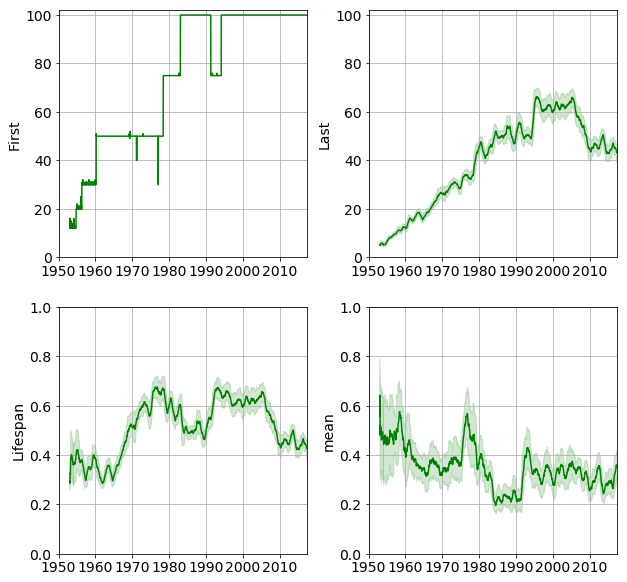

In [46]:
# TO SKIP -- plot setup

fig, axes = plt.subplots(2, 2, gridspec_kw = {'wspace' : 0.25})
fig.set_size_inches(10, 10)

for ax, data_, label in zip(axes.flat, data, labels):
    
    x = np.arange(len(data_))
    
    if isinstance(data_, pd.DataFrame):
        
        ax.plot(x, data_['mean'], color = 'green')
        ax.fill_between(x, data_['mean-std'], data_['mean+std'],
                        color = 'forestgreen', alpha = 0.2)
    else:
        ax.plot(x, data_, color = 'green')
        
    ax.set_ylabel(label)
    ax.set_xlim((0, 3500))
    ax.grid(True)
    
    ax.set_xticks([0, 520, 1040, 1560, 2080, 2600, 3120])
    ax.set_xticklabels(['1950', '1960', '1970', '1980', '1990', '2000', '2010'])

axes[0,0].set_ylim((0, 102)); axes[0, 1].set_ylim((0, 102))
axes[1,0].set_ylim((0, 1)); axes[1, 1].set_ylim((0, 1))
 
plt.show()

### Epochs

We now have all the tools to characterise the time evolution of the UK singles chart. The label density reveals how many labels compete for the chart positions on a given week. The label diversity is an indicator of the balancedness of the competition. An epoch is defined as an interval within the density and diversity behaved consistently _e.g._ both increased, one increased, the other remained unchanged _etc_. 

An approximate division into epochs is shown in the figure below.

In [13]:
# TO SKIP -- plot setup

# approximate epoch limits
limits = (np.array([1950, 1955, 1957, 1958.5,
                    1960, 1965, 
                    1974.5, 1976, 
                    1982.5, 1984, 
                    1990, 1993, 1997, 
                    2005, 2010, 2019]) - 1950) * 52

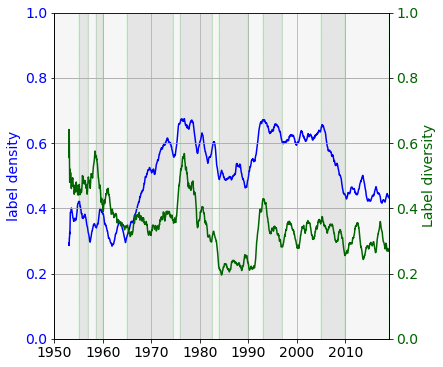

In [60]:
# TO SKIP -- plot setup

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6, 6)

ax.plot(np.arange(len(r_d_smooth)), r_d_smooth['mean'], label = 'label density',
        color = 'blue')

ax.grid(True)
ax.set_xlim(0, len(r_d_smooth)); ax.set_ylim(0,1)
ax.set_yticklabels([str(x)[:3] for x in ax.get_yticks()], color = 'blue')
ax.set_ylabel('label density', color = 'blue')

ax.set_xticks([0, 520, 1040, 1560, 2080, 2600, 3120])
ax.set_xticklabels(['1950', '1960', '1970', '1980', '1990', '2000', '2010'])

ax2 = ax.twinx()
ax2.plot(np.arange(len(r_g_smooth)), r_g_smooth['mean'], label = 'Label diversity',
       color = 'darkgreen')

ax2.grid(True)
ax2.set_xlim(0, len(r_g_smooth)); ax2.set_ylim(0,1)
ax2.set_yticklabels([str(x)[:3] for x in ax2.get_yticks()], color = 'darkgreen')
ax2.set_ylabel('Label diversity', color = 'darkgreen')

for x in limits:
    ax.axvline(x =x, linewidth = 0.2, color = 'lime', linestyle = '--')

colors = cycle(['lightgrey', 'grey'])
for x1, x2, color in zip(limits[:-1], limits[1:], colors):
    ax.axvspan(x1, x2, alpha = 0.2, color = color)
    
plt.show()

The following periods can be identified based on the measures label density and label diversity.
	
* **1953--1955:** the noise level does not permit for pinning down a trend.

* **1955--1957:** density decreases, diversity remain constant: progressively fewer labels compete,  whilst the singles are distributed among them in roughly the same pattern.
	
* **1957--1958:** density increases, diversity increases: labels are present weekly, positions are more uniformly distributed.

* **1958--1960:}** density increases, diversity deceases. More labels appear but few of them starts to dominate.
	
* **1960--1965:** density remains low and oscillates due to the low number of competitors. Diversity decreases indicating a more and more unbalanced competition.. 
	
* **1965--1974:** label density steadily increased whilst the diversity remained almost constant. The market was constantly redistributed between the labels, keeping the relative share of each label roughly constant. 
	
* **1974--1976:** sudden increase both in the density and diversity. Each label now had a smaller share of the positions, the market was open to accommodate a large number of labels.
	
* **1976--1982:**  both quantities decrease, meaning the competition became stiffer, with many labels eliminating. Those remaining had disproportionally large share of the positions.

* **1982--1983:** sees a dramatic drop in the density and diversity corresponding to fewer labels dominating the market. Also, MTV arrived in 1981.

* **1983--1990:** the charts are stable.

* **1990--1994:** more competitors (density rises), and more balanced competition (diversity rises)

* **1994--1997:** the number of competitors slightly declines, but the charts are dominated by progressively fewer of them.

* **1997--2005:** the status quo is maintained.

* **2005--2010:** on average one third of the competing labels are eliminated. The marker also become less balanced. 

* **2005--2018:** the charts are stable.


#### Analysis of epochs

We set out to determine the possible causes of the trends.

The year and number of positions for each week are retrieved from the raw data. One can alternatively use pandas wizzardry and equisite column selection rules to achieve the same, but I prefer a stream-like solution.

In [15]:
with open(r'C:\Users\hornu\OneDrive\Documents\repos\chart-singles\data-collection\data\raw-singles-1953-2018.json', 'r') as fproc:
    data_ = json.load(fproc)

# for each week get the number of chart positions crop at 100
n_positions = [min(100, len(x['labels'])) for x in data_]
weights = [100.0 / x for x in n_positions]

# for each week get the corresponding year
years = [int(x['url'].split('/')[-3][:4]) for x in data_]

In [16]:
def repeat_interable_factory(iterable, repeats = 100):
    while True:
        yield chain(*(repeat(x, repeats) for x in iterable))

years_long = repeat_interable_factory(years)
weights_long = repeat_interable_factory(weights)

The `collector` function gathers the following information for each and every label.

* `first`: year of first appearance
* `last`: year of last appearance
* `pos`: sum of positions (to calculate mean later on)
* `cnt` : overall count
* `f_pos`: sum of positions in the first half year
* `f_cnt`: count in first half year

A dataframe, `appearances_df` is created to store the statistics. 

In [17]:
appearance = collector(label_series, next(weights_long), next(years_long))

# remove nan
_ = appearance.pop(5, None)

# recast as dataframe
appearances_df = pd.DataFrame.from_dict(appearance, orient = 'index')

#### New and departing labels.

In the histogram below, each dot corresponds to a collection of labels which charted their first single in the year marked on the abscissa and the year of the their last single appeared in the year on the ordinate. Darker colours signify a greater number of labels in the collection.

In other words a point in the histogram is proportional to the probability:

$$
P(x,y) = P(\textit{label first appears in year } \textbf{x}, \textit{ label last appears in year } \textbf{y})
$$

The marginal distributions are plotted along the 2D histogram. The distribution on the top is the probability of a new label rising in a given year, whereas the distribution on the left is the probability of label going defunct in a given year. 

The label diversity and density traces are overlaid on the histogram. 

##### How to read this histogram? 

* Pick a year or a range on the x-axes
* Go upwards until the diagonal is reached
* The points above the diagonal are labels that were new in the selected range.
* Pick a point or group of points
* Go leftwards to the ordinate
* The year on the axis is the one when the label went defunct.
* Then go rightwards horizontally until the marginal histogram is reached
* The marginal histogram tells us if a major extinction event happened in that year

In [18]:
# TO SKIP -- plot setup

death_kwargs = {'xlim' : (1950, 2020),
                'ylim' : (1950, 2020),
                'xlabel' : 'Year of first single',
                'ylabel' : 'Year of last single',
                'xticks' : [1950, 1960, 1970, 1980, 1990, 2000, 2010],
                'yticks' : [1950, 1960, 1970, 1980, 1990, 2000, 2010]}

death_kwargs.update({'xticklabels' : [str(x) for x in death_kwargs['xticks']],
                     'yticklabels' : [str(x) for x in death_kwargs['yticks']]})

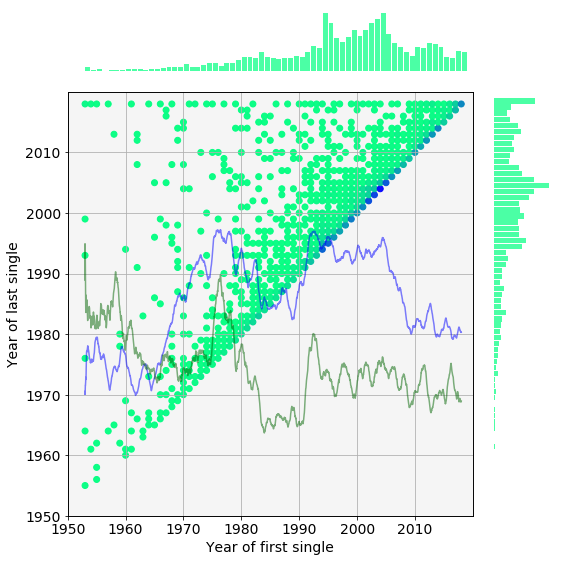

In [19]:
# TO SKIP -- plot setup

axes = joint_plot(appearances_df['first'].values, appearances_df['last'].values, 
                  cmap = plt.get_cmap('winter_r'), color = 'springgreen',
                  **death_kwargs)

x_range = np.linspace(1950, 2018, num = r_d_smooth['mean'].values.shape[0])
extra_traces = ((x_range, r_d_smooth['mean'].values, 'blue'), (x_range, r_g_smooth['mean'].values, 'darkgreen'))

add_plots_to_axis(axes[0], extra_traces, **{'xlim' : (1950, 2020), 'ylim' : (0, 1)})
plt.show()

Please note these distributions are not corrected for the the varying number of weekly chart positions. Nevertheless, a few observations can be made.  

* A horizontal line represents the conditional probability of a label departing in a certain year given it came about in the year marked on the abscissa.

* The closer the points are to the diagonal the shorter they lived. 

* The points on the diagonal correspond to labels which which were active for only one year. 

For example, there were many ephemeral labels between 2002 and 2008 indicated by the high probabilities on the diagonal. Most of the labels that appeared in this period had been busted by 2015 which creates a local maximum in the extiction probability on the left. The number of new labels also steadily decreases throughout these years. As they are gradually, eliminated the label density plunges, so does the diversity.

##### Statistics normalised by yearly position counts.

As we noted above, the histogram should depend on the number of yearly positions. We therefore develop a handful of measures that take into account the variation of the chart length.

The number of total positions of each year, $N^{P}_{i}$, is calculated and stored in the `pos_per_year_df` dataframe.

In [20]:
# here goes a beautiful one-liner 
pos_per_year =  {k : sum(map(lambda x: x[0], g)) 
                     for k, g in groupby(zip(n_positions, years), key = lambda x: x[1])}

pos_per_year_df = pd.DataFrame.from_dict(pos_per_year, orient = 'index', columns = ['cnt_total'])

Then the weights of each year is defined as the ratio of maximum positions (~5,200) and the number of positions in the years in question.

In [21]:
# no, I won't use merge

pos_per_year_weights = {k : max(pos_per_year.values()) / v for k, v in pos_per_year.items()}
appearances_df['w_first'] = appearances_df['first'].apply(lambda x: pos_per_year_weights[x])
appearances_df['w_last'] = appearances_df['last'].apply(lambda x: pos_per_year_weights[x])

The histogram is plotted again, now corrected for the uneven number of yearly positions. As expected, the distribution changed substantially ony the first few decades (there were at least 75 positions since 1978). A band of extiction (pale blue of diagonal stripe) between 1977 and 1985 becomes more visible. This band which coincides with the decreasing density and diversity. Notwithstanding this histogram contains a plethora of information, some quantities derived from it will help us to better understand the underlying processes.

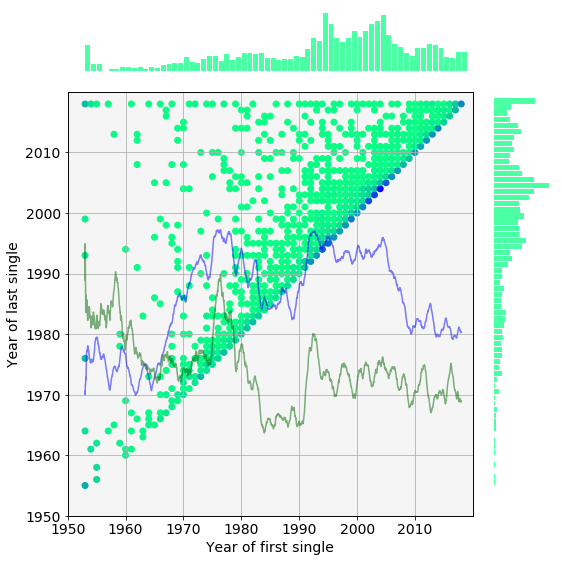

In [30]:
# TO SKIP -- plot setup

axes = joint_plot(appearances_df['first'].values, appearances_df['last'].values, 
                  w_x = appearances_df['w_first'], w_y = appearances_df['w_last'], 
                  **death_kwargs)

x_range = np.linspace(1950, 2018, num = r_d_smooth['mean'].values.shape[0])
extra_traces = ((x_range, r_d_smooth['mean'].values, 'blue'), (x_range, r_g_smooth['mean'].values, 'darkgreen'))

add_plots_to_axis(axes[0], extra_traces,  **{'xlim' : (1950, 2020), 'ylim' : (0, 1)})
plt.show()

#### Survival analysis

In the following we attemp to resolve the labels that became defunct in a given year. We chose cohorts from years that immediately preceed or from major changes. A label is assumed alive if it charted in 2017 or 2018. We use the conditional probability:

$$
P(x_{last} = x | x_{first})
$$

which measures the probability of labels from a particular years disappearing over the decades. The probabilities are plotted in the top row of the figure below next to the associated survival functions. (Please note, the survival functions should be extended to the right ordinate.)

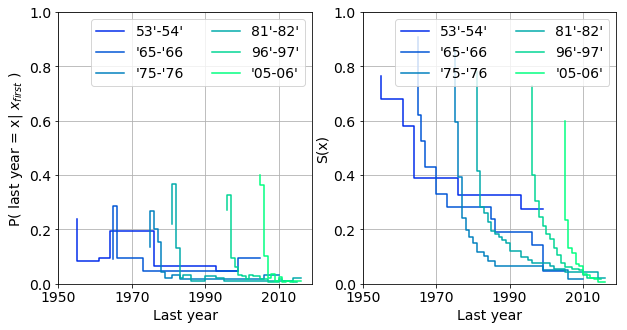

In [23]:
# TO SKIP -- plot setup

histo = calculate_histo_2d(appearances_df['first'].values, 
                   appearances_df['last'].values, 
                   (1950, 2018), (1950, 2018),
                   w_x = appearances_df['w_first'],
                   w_y = appearances_df['w_last'])

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

plot_kwargs = {'ylim' : (0,1.0), 
               'xlabel' : 'Last year', 
               'xticks' : [1950, 1970, 1990, 2010]}

# P(death | birth = year)
plot_kwargs.update({'ylabel' :r'P( last year = x| $x_{first}$ )'})
x_sel = [[1953, 1954], [1965, 1966], [1975, 1976], [1981, 1982], [1996, 1997], [2005, 2006]]
labels = ["53'-54'","'65-'66", "'75-'76", "81'-82'", "96'-97'", "'05-06'"]

xs_ys = [calc_average_probability_from_coo_histo(histo, xs = x, exclude_values = [2017, 2018]) for x in x_sel]
xs, ys = zip(*(xs_ys))

plot_lines(xs, ys, labels, axes[0], kind = 'step', cmap = plt.get_cmap('winter'), alpha = 1.0, **plot_kwargs)

# survival function
plot_kwargs.update({'ylabel' : 'S(x)'})
ys = [1 - np.cumsum(y) for y in ys]
plot_lines(xs, ys, labels, axes[1], kind = 'step', cmap = plt.get_cmap('winter'), alpha = 1.0, **plot_kwargs)

The labels are most likely to go out of busines in their very first years. This is reflected as the initial jumps of the probability functions and drops of the associated survival functions.

The various cohorts can indeed behave differently. 

* oldest labels **('55-'56)** are practically indestructible. They survived the mass extiction of the eighties. These labels were already established by the fifties, _e.g._ Capitol, wich had more resistance to major restructuring of the music industry. 

* labels from the **'70's and '80's** barely survive into the mid nineties. 

* The life expentancy of the younger labels is yet smaller. The cohort from **'05 and '06** consists of mainly ephemeral labels majority of which vanish in the first year they charted. 

* Interestingly enough, the otherwise resistant group of **'65-'66** which survived the eighties at a healthy 20%, slowly wither during the second half of the nineties.

Finally, we determine labels from what years were hit hard by a particular extiction event. We use the conditional probability:

$$
P(x_{first} = x | x_{last})
$$

that is a probability of a label coming into existence across the years, given it went out of business in a fixed year. The probability and associated survival functions are plotted for a selection of cohorts below. These plots can be interpreted as how selective a year's extinction is. Does is affect labels from different periods to different extent?

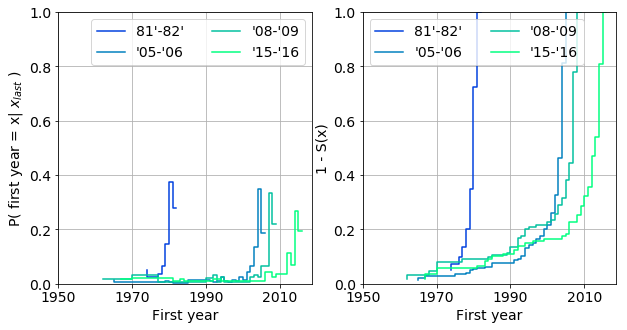

In [24]:
# TO SKIP -- plot setup

fig, axes = plt.subplots(1, 2)
fig.set_size_inches(10, 5)

# P(birth | death = year)
plot_kwargs.update({'ylabel' :r'P( first year = x| $x_{last}$ )'})
y_sel = [[1981, 1982], [2005, 2006], [2008, 2009], [2015, 2016]]
labels = ["81'-82'","'05-'06", "'08-'09", "'15-'16"]

xs_ys = [calc_average_probability_from_coo_histo(histo, ys = y) for y in y_sel]
xs, ys = zip(*(xs_ys))
plot_kwargs.update({'xlabel' : 'First year'})

plot_lines(xs, ys, labels, axes[0], kind = 'step', cmap = plt.get_cmap('winter'), alpha = 1.0, **plot_kwargs)

# survival function
plot_kwargs.update({'ylabel' : '1 - S(x)'})
ys = [np.cumsum(y) for y in ys]
plot_lines(xs, ys, labels, axes[1], kind = 'step', cmap = plt.get_cmap('winter'), alpha = 1.0, **plot_kwargs)

plt.show()

General observations:

* labels that became defunct in a certain year a more likely to be young ones. For example, 90% of the labels that vanished in **'81-82** were from the period of '79 and '81.

* The pool of labels from a particular period succesively diminishes over the years: 15%, 10% and 5% of the labels are from between **'90-'00** which vanished in years '05-'06, '08-'09, '15-'16.

Any deviations from these rules, serves with additional information on the labels. Such as,

* 10% of the labels disappeared between '08-'09 and '15-'16 are from between '67 and '80. However, the ratio is expected to be lower in '15-'16. 

More detailed insight could be gained based upon life tables. For the sake of brevity, it is omitted from this digression.

##### Fraction of new, old and departing labels

In this section we further quantify observations above by taking into account the number of yearly positions.

Let us denote the set of unique labels in year $i$ by $\mathcal{L}_{i}$. The set of new labels, $\mathcal{S}^{N}_{i}$ in year $i$ is defined as:
$$
\mathcal{S}^{N}_{i} = \mathcal{L_{i}} - \bigcup\limits_{j < i} \mathcal{L}_{j} \, .
$$
Likewise, the set of old labels, $\mathcal{S}^{O}_{i}$ which have appeared in the year before $i$:
$$
\mathcal{S}^{O}_{i} = \mathcal{L_{i}} \cap \bigcup\limits_{j < i} \mathcal{L}_{j} \, .
$$

The set of departing labels in year $i$, $\mathcal{S}^{D}_{i}$ is the collection of labels that do not appear after year $i$.

$$
\mathcal{S}^{D}_{i} = \mathcal{L}_{i} - \bigcup\limits_{i<j}\mathcal{L}_{j}
$$

The number of new and departing labels, $|\mathcal{S}^{N}_{i}|, |\mathcal{S}^{D}_{i}|$ are easily obtained by a groupby operation on the `first` and `last` columns. We can then proeed to calculate the fraction of newborn
$$
    F^{Ln}_{Yi} = \frac{|\mathcal{S}^{N}_{i}|}{|\mathcal{L}_{i}|} \, ,
$$

old

$$
F^{Lo}_{Yi} = 1 - F^{Ln}_{Yi} \, ,
$$

and departing 
$$
    F^{Ld}_{Yi} = \frac{|\mathcal{S}^{D}_{i}|}{|\mathcal{L}_{i}|}
$$
labels in each year in the `label_per_year_stats_df` dataframe.

In [25]:
# whoaa! an other one
label_per_year = {k : set(map(lambda x: x[0], g)) 
                      for k, g in groupby(zip(label_series, next(years_long)), key = lambda x: x[1])}

# substract nan (index 5) and count unique indices
label_per_year_ = {k : len(v - {5})  for k, v in label_per_year.items()}
# to dataframe
label_per_year_df = pd.DataFrame.from_dict(label_per_year_, orient = 'index', columns = ['cnt_total'])

In [26]:
# merge stats
label_per_year_stats_df = pd.concat([label_per_year_df, 
                                     appearances_df.groupby(['first']).size(), 
                                     appearances_df.groupby(['last']).size()],
                                      axis = 1) 
label_per_year_stats_df.columns = ['cnt_total', 'cnt_new', 'cnt_last']

# calculate newborn and departing fractions
label_per_year_stats_df['fraction_new'] = label_per_year_stats_df['cnt_new'] / label_per_year_stats_df['cnt_total']
label_per_year_stats_df['fraction_last'] = label_per_year_stats_df['cnt_last'] / label_per_year_stats_df['cnt_total']
label_per_year_stats_df['fraction_old'] = 1 - label_per_year_stats_df['fraction_new']

##### Label performance

We also calculate how strongly the new and old (already charted labels perform) in each year. The measure is the average position $v_{lj}$ of label $l$ weighted by the number of appearances of $l$ in the given year, $n_{l}$.

$$
R^{N}_{i} = \frac{\sum\limits_{l \in \mathcal{S}^{N}_{i}} \sum\limits_{j = 1}^{n_{l}} v_{lj}} 
{ \sum\limits_{l \in \mathcal{S}^{N}_{i}} n_{l}}
$$

The equivalent measure of the old labels, $R^{O}_{i}$, is easily obtained knowing the overall performance of the the labels, $R_{i}$ is constant (0.505).

$$
R_{i} = \frac{ \sum\limits_{l \in \mathcal{S}^{N}_{i}} n_{l}  }{N^{P}_{i}} \cdot R^{N}_{i} + \frac{\sum\limits_{l \in \mathcal{S}^{O}_{i}} n_{l}   }{N^{P}_{i}} \cdot R^{O}_{i} = F^{Pn}_{Yi} \cdot R^{N}_{i} + F^{Po}_{Yi} \cdot R^{O}_{i}
$$

The performance metrics are collected in the `label_performance_df` dataframe.

In [27]:
label_performance_df = appearances_df.groupby(['first']).agg({'pos_first' : sum, 'cnt_first' : sum})

# add number of total positions per year
label_performance_df = pd.concat([label_performance_df, pos_per_year_df], axis = 1)
          
# fraction of position of new labels
label_performance_df['fp_new'] = label_performance_df['cnt_first'] / label_performance_df['cnt_total']

# number positions of old labels
label_performance_df['cnt_old'] = label_performance_df['cnt_total']  - label_performance_df['cnt_first']

# fraction of positions of old labels
label_performance_df['fp_old'] = label_performance_df['cnt_old']  / label_performance_df['cnt_total']

# performance of new labels
label_performance_df['r_new'] = label_performance_df['pos_first'] / label_performance_df['cnt_first']

# performance of old labels
label_performance_df['r_old'] = (50.5 - label_performance_df['fp_new'] * label_performance_df['r_new']) \
                                 / label_performance_df['fp_old']

The figure below provides a graphical summary of the quantities we just introduced. The fraction of new and old labels $F^{Ln}_{Yi}, F^{Lo}_{Yi}$ (top left panel), the fraction of positions held by new and old labels, $F^{Pn}_{Yi}, F^{Po}_{Yi}$, (top right panel) and the performances, $ R^{N}_{i},  R^{O}_{i}$ (bottom left panel) are shown. The label density and diversity are overlaid on the plots as half-tone curves.

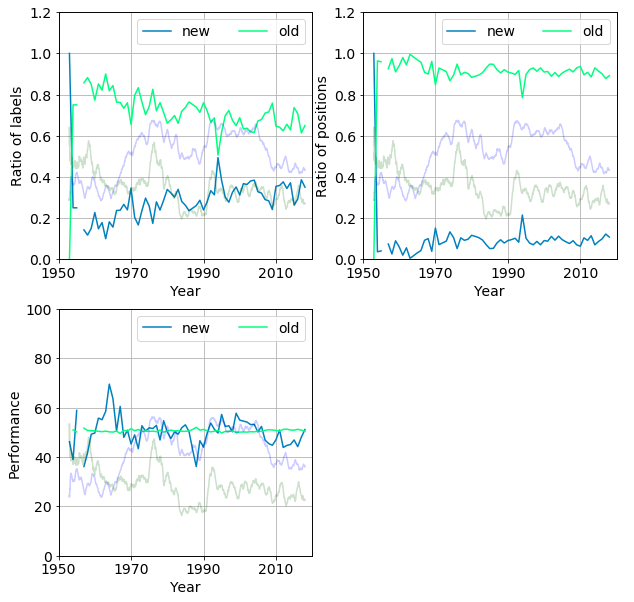

In [28]:
# TO SKIP -- plot setup

fig, axes = plt.subplots(2, 2)
fig.set_size_inches(10, 10)

plot_kwargs = {'xlim' : (1950, 2020), 'ylim' : (0, 1.2), 
               'xticks' : (1950, 1970, 1990, 2010),
               'xlabel' : 'Year'}

labels = ('new', 'old')

# years
xs = (label_performance_df.index, label_performance_df.index)

# ratio of labels
ys_fl = (label_per_year_stats_df[['fraction_new', 'fraction_old']].values.T)

# ratio of positions
ys_fp = (label_performance_df[['fp_new', 'fp_old']].values.T)

# performance
ys_r = (label_performance_df[['r_new', 'r_old']].values.T)

# plot all
plot_kwargs.update({'ylabel' : 'Ratio of labels'})
plot_lines(xs, ys_fl, labels, axes[0, 0], cmap = plt.get_cmap('winter'), **plot_kwargs)

plot_kwargs.update({'ylabel' : 'Ratio of positions'})
plot_lines(xs, ys_fp, labels, axes[0, 1], cmap = plt.get_cmap('winter'), **plot_kwargs)

plot_kwargs.update({'ylabel' : 'Performance', 'ylim' : (0, 100)})
plot_lines(xs, ys_r, labels, axes[1, 0], cmap = plt.get_cmap('winter'), **plot_kwargs)

# overlay density and diversity
add_plots_to_axis(axes[0, 0], extra_traces, **{'xlim' : (1950, 2020), 'ylim' : (0, 1.2), 'alpha' : 0.2})
add_plots_to_axis(axes[0, 1], extra_traces, **{'xlim' : (1950, 2020), 'ylim' : (0, 1.2), 'alpha' : 0.2})
add_plots_to_axis(axes[1, 0], extra_traces, **{'xlim' : (1950, 2020), 'ylim' : (0, 1.2), 'alpha' : 0.2})
axes[1,1].set_axis_off()
plt.show()

The following can be observed

* Seemingly the fraction of new labels per year increase over time, from 0.4 to 0.8 between 1960 and 2018. 

* However, the ratio of their positions fluctuates around 0.1 and exhibits and erratic slight increasing trend. This makes sense for a new label requires time to carve out its market share. Only newborn labels with strong parents (_i.e_ result of a merger or acquisition) can instantly cover large ranges of positions by issuing the work of their previously contracted artists. 

* between **1975 and 1988**. The both the fraction and the positions of the new labels decrease. The performance also stagnates then plummets. These labels just did not perform well enough to sustain themselves, due the the dominance of old labels.

* starting in **'89** the new publishers gradually break up the status quo which results in the increase of density and diversity.

An other scenario that may result in new labels gaining ground, if there are many of them. 

* in **1993** almost half of the publishers were new, which pushed up their coverage from 10% to 20%. 
* this spike then quickly melted into the baseline by **1995**. It is worth noting, the new labels performed better than the old ones in the nineties (pale blue trace in bottom right panel).

* After **1997** the performance of the new arrivals descends below the quasi constant average position of the old ones. This signifies that they cannot gain ground in a field ruled by the established labels. There is still a steady influx of labels but they drop out quickly as we seen it on the histogram.

## Summary and future work

### Main findings

* We developed simple measures to describe the dynamics of the temporal evolution of the UK singles chart. Label density and diversity gauges the breadth and balancedness of the competition.

* We used durvival analysis to identify various groups of labels. It is found that the majority of the labels exist for only a few years. It has also been revealed that older labels are more resistant to changes of the market.

* We defined the label performance as the average position. Low performance leads to depletion of new labels.

### Possibilities

* include historical relationships between labels, such as acquisition and merger, in the analysis

* Use more granular data to delineate clusters of labels according to their time evolution

* Refine the role of performance in the expected life span of labels

* Use clustering to uncover label strategies

#### A little teaser from the next post:

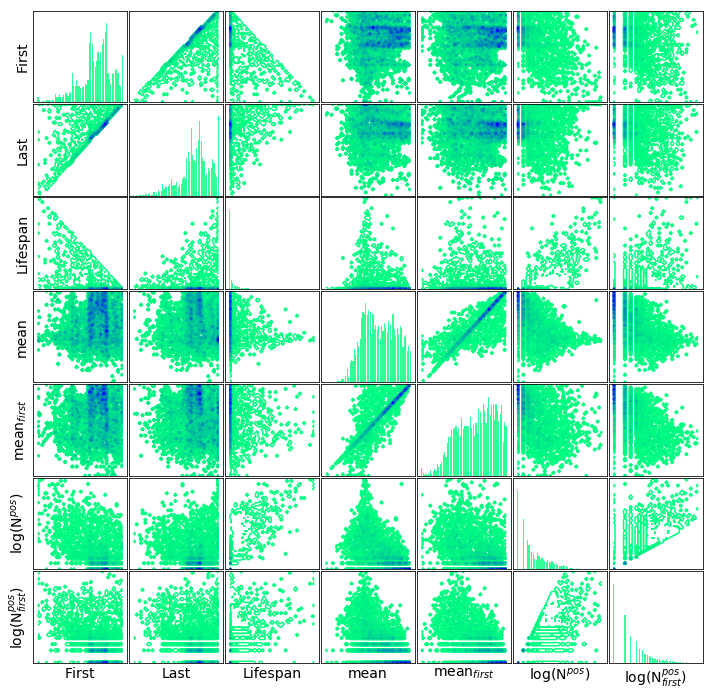

In [29]:
# TO SKIP -- plot setup

appearances_df['delta'] = appearances_df['last'] - appearances_df['first']
appearances_df['mean_tot'] = appearances_df['pos'] / appearances_df['cnt']
appearances_df['mean_first'] = appearances_df['pos_first'] / appearances_df['cnt_first']
appearances_df['log_cnt'] = np.log(appearances_df['cnt'])
appearances_df['log_cnt_first'] = np.log(appearances_df['cnt_first'])

sel = ['first', 'last', 'delta', 'mean_tot', 'mean_first', 'log_cnt', 'log_cnt_first']
labels = ['First', 'Last', 'Lifespan', 'mean', r'mean$_{first}$', r'log(N$^{pos}$)', r'log(N$^{pos}_{first}$)' ]

plot_pair_grid(appearances_df, n_bins = 60, labels = labels, sel = sel)

plt.show()